# Notebook 4: Simple Bidding Strategies
In this notebook, several bidding strategies are implemented. We make use of the data that was tailor made for our needs in the previous notebook.

In [1]:
#Dependancies and Utilities.
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

In [2]:
from preprocessCSV import *
from featurize import *

## Loading the data

In [3]:
train = pd.read_csv('Data/train.csv')
validate = pd.read_csv('Data/validation.csv')
for data in [train,validate]:
    data.drop(columns = ['Unnamed: 0'], axis =1, inplace=True)
    data = numerise_features(data)
    data = categorize_features(data)

## Constant and Random Bidding Strategy

Stright off the bat we build a *SimpleBidSimulator* class which runs bids based on constant bids and random bids. This provides a benchmark for the comparison of other models developed using machine learning tecjniques.

**Constant Bidding Strategy:** The optimum bid placed at each stage is a constant and does not make use of any data  patterns.

**Random Bidding Strategy:** Given an upper bound, a random number is generated which plays the role of the bid. The upper bound can be thought of as the maximum budget the advertiser can spend.

In [4]:
class SimpleBidSimulator():
    '''
    A class for running auctions for on constant and random bidding
    strategy advertisers.
    '''
    def __init__(self,Bidder,data):
        '''
        Bidder is the advertiser and data is the df against which results 
        are to valuated
        '''
        self.bidder = Bidder 
        self.D = data.loc[:,['click','paying_price']]
        #Determining the bounds of bid based on the validatin dataset.
        self.minBid = np.min(data['paying_price'].values)
        self.maxBid = np.max(data['paying_price'].values)
        #Possible values of bidding price.
        self.base_bids = np.arange(self.minBid+5,self.maxBid+10,Bidder.interval)
        self.imp_lst   = []
        self.clk_lst   = []
        self.ctr_lst   = []
        self.spend_lst = []
        self.cpc_lst   = []
        self.bids      = None
        
        
    def evaluate_bids(self):
        '''
        A method that compares the bid placed by the created bidder against
        what was already observed in the validation dataset.
        '''
        budget = self.bidder.budget
        clicks = 0
        imps   = 0
        spend   = 0
        
        for bid,click,pay_price in self.D[['bids','click','paying_price']].values:
            if bid > pay_price:
                imps   += 1
                clicks += click
                spend   += pay_price
            if spend >= budget:
                break
        return imps,clicks,spend
        
        
    def run_bids(self):
        '''
        A method that runs bids by using base bid as prices specified in base_bids.
        '''
        for base_bid in self.base_bids:
            self.D['base_bid'] = base_bid
            self.bids = self.bidder.get_bid(self.D['base_bid'].values)
            self.D['bids'] = self.bids
            imps,clicks,spend = self.evaluate_bids()
            ctr = np.nan
            if imps != 0:
                ctr = clicks*100/imps
            cpc = np.nan
            if clicks != 0:
                cpc = spend/clicks
            self.imp_lst.append(imps)
            self.clk_lst.append(clicks)
            self.spend_lst.append(spend)
            self.ctr_lst.append(ctr)
            self.cpc_lst.append(cpc)
            self.D.drop(columns=['base_bid','bids'],axis=1,inplace=True)

    def get_summary(self):
        '''
        Prints out the results of the austions run as a pandas dataframe.
        '''
        summary = pd.DataFrame()
        summary['Bid Upper Bound'] = self.base_bids
        summary['Impressions']  = self.imp_lst
        summary['Clicks']       = self.clk_lst
        summary['Amount Spend'] = self.spend_lst
        summary['CTR'] = self.ctr_lst
        summary['CPC'] = self.cpc_lst
        summary.dropna()
        return summary

In [5]:
class ConstantBidder():
    '''
    A bidder who bids foloows the constant price
    strategy.
    '''
    def __init__(self,budget):
        self.budget = budget
        self.interval =2
    def get_bid(self,base_bids):
        return base_bids
    def get_lower_bound(self):
        pass


class RandomBidder():
    '''
    A bidder who bids foloows the random bid price
    strategy.
    He generates a random bid between [lower_bound,upper_bound].
    '''
    def __init__(self, budget, lower_bound=0):
        self.budget = budget
        self.interval = 20
        self.lower_bound = lower_bound

    def get_bid(self, base_bids, lower_bound=0):

        bids = [
            0 if upper_bound <= self.lower_bound else randrange(
                self.lower_bound, upper_bound) for upper_bound in base_bids
        ]
        return bids

In [6]:
#Defining the bidders.
budget = 100000
constantBidder = ConstantBidder(budget)
randomBidder = RandomBidder(budget)


### Validating the constant and random bid strategy

#### Constant Strategy

In [7]:
#Selecting 20000 points for easier evaluation.
validate = validate[:20000]

In [8]:
bidSim = SimpleBidSimulator(constantBidder,validate)
bidSim.run_bids()

In [9]:
constantBidder_stats = bidSim.get_summary()
desc = constantBidder_stats[['Clicks','CTR']].describe()
display('constantBidder_stats','desc')

,Bid Upper Bound,Impressions,Clicks,Amount Spend,CTR,CPC
0,6,434,0,2038,0.000000,NaN
1,8,614,0,3234,0.000000,NaN
2,10,783,0,4683,0.000000,NaN
3,12,1106,0,8067,0.000000,NaN
4,14,1294,0,10409,0.000000,NaN
...,...,...,...,...,...,...
147,300,1309,1,100010,0.076394,100010.0
148,302,1306,1,100024,0.076570,100024.0
149,304,1306,1,100024,0.076570,100024.0
150,306,1306,1,100024,0.076570,100024.0


As can be seen from the table above, the highest number of clicks received is 2 and the highest CTR is 0.141143%.  The correspondong optimal bid for that can be found by,

In [10]:
filt = (constantBidder_stats['CTR'] == constantBidder_stats['CTR'].max() )
opt_bid = constantBidder_stats[filt]
opt_bid

,Bid Upper Bound,Impressions,Clicks,Amount Spend,CTR,CPC
108,222,1414,2,100120,0.141443,50060.0


* In order to achieve the highest clicks and CTR, the advertiser has to constantly bid an amount of 221

Text(0, 0.5, 'Clicks')

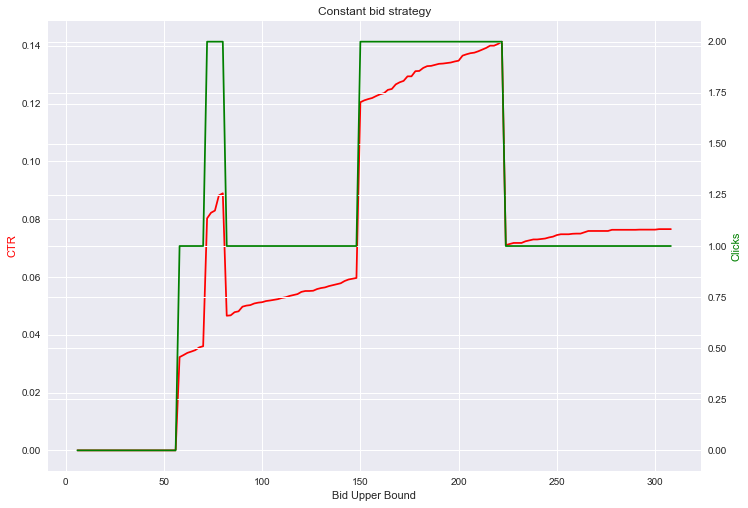

In [11]:
#Defining a figure
fig, ax1 = plt.subplots(1, 1, figsize=(11.7, 8.27))
kargs1 = {
    'x': 'Bid Upper Bound',
    'y': 'CTR',
    'data': constantBidder_stats,
    'color': 'red'
}

kargs2 = {
    'x': 'Bid Upper Bound',
    'y': 'Clicks',
    'data': constantBidder_stats,
    'color': 'green'
}

ax1.set_title('Constant bid strategy')
ax1 = sns.lineplot(**kargs1)
ax1.set_ylabel('CTR', color='r')

ax2 = ax1.twinx()
ax2 = sns.lineplot(**kargs2)
ax2.set_ylabel('Clicks', color='green')

* Even a simple strategy like the constant bids has significantly improved CTR.
* As can be inferred form the plot above the number of clicks keeps on increasing until the bid value is high enough such that the total budget is spend. 
* After that point the number of clciks gradually decreases and reaches a constsant value.
* At this constant value the advertiser buys all the impressions at payprice until the budget runs out. 

In [12]:
bidSim = SimpleBidSimulator(randomBidder,validate)
bidSim.run_bids()

In [13]:
randomBidder_stats = bidSim.get_summary()
desc = randomBidder_stats[['Clicks','CTR']].describe()
display('randomBidder_stats','desc')

,Bid Upper Bound,Impressions,Clicks,Amount Spend,CTR,CPC
0,6,23,0,71,0.000000,NaN
1,26,1364,0,15826,0.000000,NaN
2,46,2767,0,47236,0.000000,NaN
3,66,4113,0,100033,0.000000,NaN
4,86,3036,1,100029,0.032938,100029.0
5,106,2529,1,100020,0.039541,100020.0
6,126,2293,3,100044,0.130833,33348.0
7,146,2137,2,100023,0.093589,50011.5
8,166,2044,0,100023,0.000000,NaN
9,186,1920,1,100017,0.052083,100017.0


In [14]:
#Lower Bound trials.
lower_bounds = np.arange(0,300,20)
grid_df = pd.DataFrame()
for lb in lower_bounds:
    random_bidder = RandomBidder(budget,lb)
    bidSim = SimpleBidSimulator(random_bidder,validate)
    bidSim.run_bids()
    df_ = bidSim.get_summary()
    df_ = df_[['Bid Upper Bound','Clicks']]
    df_['Bid Lower Bound'] = lb
    grid_df = pd.concat([grid_df,df_],ignore_index = True)

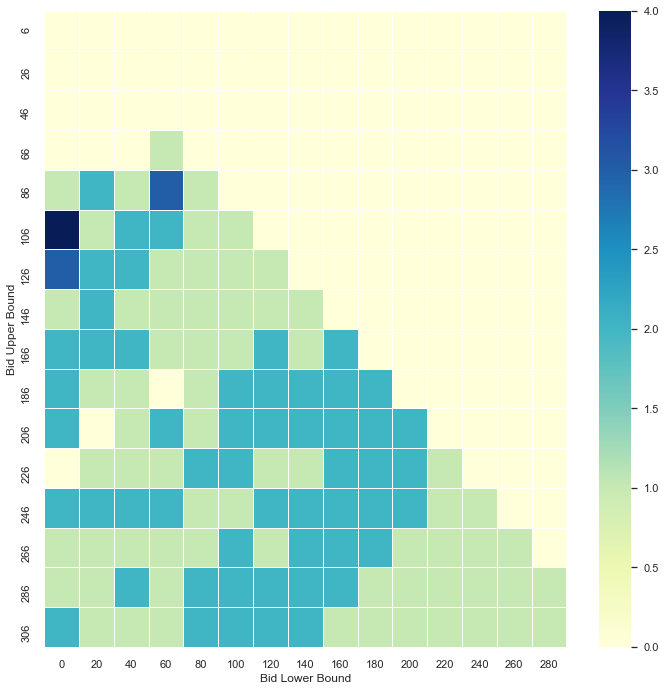

In [15]:
#Producing a heat map.
sns.set(rc={'figure.figsize':(11.7,11.7)})
grid_df_map= grid_df.pivot('Bid Upper Bound','Bid Lower Bound','Clicks')
ax = sns.heatmap(grid_df_map, linewidths=.5,cmap='YlGnBu')

* From the heat map we could infer the lower and upper bounds for a random bidder to be optimal (dark_blue_regions).


## Linear Bidding strategy





* Instead of randomly bidding or bidding at a constant price, we make use of the available training data and train a logistic regression model which predicts the probabilty of the CTR (pCTR).
* The logistic regression model was trained in notebook 5 and here we make use of the 'LR_pCTR_val.csv', generated in that process. It contains the pCTR for the validation dataset which can be used for valuation of the model.
* We assume a bid price formula that is linear in pCTR as the bid made by the advertiser.

$$\text{Bidding Price} = \text{Base Bid} \times \frac{pCTR}{\text{Average pCTR} } $$

* Better the accracy of pCTR better will be the model.

In [16]:
#Loading the pCTR values predicted by Logistic Regression.
y_preds = pd.read_csv('LR_pCTR_val_1458.csv')
y_preds.drop(['Unnamed: 0'],axis=1,inplace=True)
y_preds = y_preds[:20000].values

In [17]:
#Avg_CTR = Total clicks/Total Impressions.
avg_CTR = train['click'].sum()*100/len(train)
print(f'The average CTR values is: {avg_CTR}')

The average CTR values is: 0.06387700747796822


In [18]:
class LinearBidder():
    '''
    A  bidder who follows the linear bidding strategy.
    '''
    def __init__(self,budget,y_preds,avg_CTR):
        self.pctr = y_preds.ravel()
        self.avg_ctr = avg_CTR
        self.interval = 10
        self.budget = budget
    
    def get_bid(self,base_bids):
        bids = np.multiply(np.array(base_bids),self.pctr)/self.avg_ctr
        return bids

In [26]:
#Defining a linear bidder.
budget = 100000
linearBidder = LinearBidder(budget,y_preds = y_preds,avg_CTR = avg_CTR)

In [27]:
#Simulating bids.
bidSim = SimpleBidSimulator(linearBidder,validate)
bidSim.run_bids()

In [28]:
linearBidder_stats = bidSim.get_summary()
desc = linearBidder_stats[['Impressions','CTR']].describe()
display('linearBidder_stats','desc')

,Bid Upper Bound,Impressions,Clicks,Amount Spend,CTR,CPC
0,6,2376,0.0,49300.0,0.000000,NaN
1,16,2022,4.0,100040.0,0.197824,25010.0
2,26,1761,2.0,100026.0,0.113572,50013.0
3,36,1600,2.0,100034.0,0.125000,50017.0
4,46,1506,2.0,100149.0,0.132802,50074.5
5,56,1436,2.0,100017.0,0.139276,50008.5
6,66,1391,2.0,100081.0,0.143781,50040.5
7,76,1356,2.0,100018.0,0.147493,50009.0
8,86,1335,2.0,100184.0,0.149813,50092.0
9,96,1326,2.0,100020.0,0.150830,50010.0


* As can be infered from the table, our model has made use of the previously available data and has made fewer bids. In the fewer bids made there was a high chance for the user to click them as denoted by the high CTR.

Text(0, 0.5, 'Clicks')

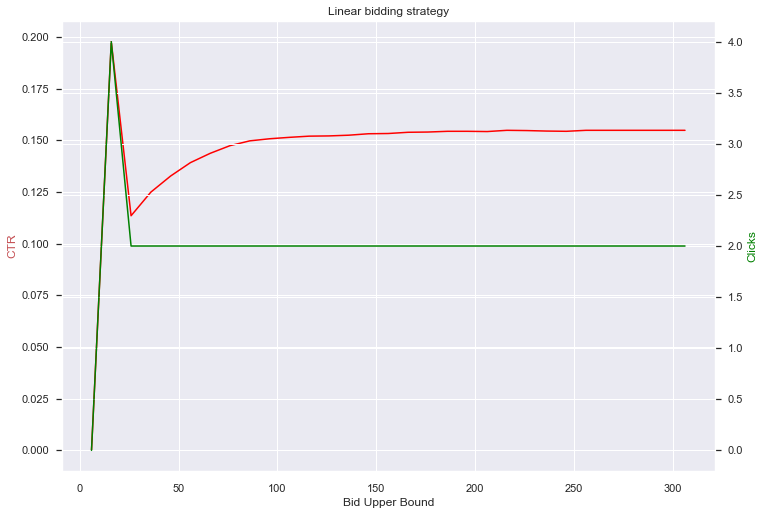

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(11.7, 8.27))
kargs1 = {
    'x': 'Bid Upper Bound',
    'y': 'CTR',
    'data': linearBidder_stats,
    'color': 'red'
}

kargs2 = {
    'x': 'Bid Upper Bound',
    'y': 'Clicks',
    'data': linearBidder_stats,
    'color': 'green'
}

ax1.set_title('Linear bidding strategy')
ax1 = sns.lineplot(**kargs1)
ax1.set_ylabel('CTR', color='r')

ax2 = ax1.twinx()
ax2 = sns.lineplot(**kargs2)
ax2.set_ylabel('Clicks', color='green')